# COMS W 4995 006 (Fall 2022)
## Deep Learning for Computer Vision
### Project Report

# 
# Automated Photo Editing using Neural Style Transfer

### Participants

Rohit V Gopalakrishnan	(rvg2119)

Adithya K Krishna		(akk2188)

Tanav Hitendra Shah (ts3469)

### Links

GitHub repository containing our working project: https://github.com/TanavShah/DLCV-Project

Presentation Video: https://drive.google.com/drive/folders/1cOJClshDOdqCC8A7odpe1IqayL_s600y?usp=sharing

# 1. Introduction

# 2. Objectives

Style transfer consists of recomposing content and style of two separated entities to create a newly generated output. In recent years, there has been several strides in applying style transfer to text, and videos as well. In this project we primarily focus on image style transfer and we aim to achieve higher quality photos, having better lighting, exposure without the use of photoshop or any image editing tools by employing style transfer technique which is not the common application of style transfer.


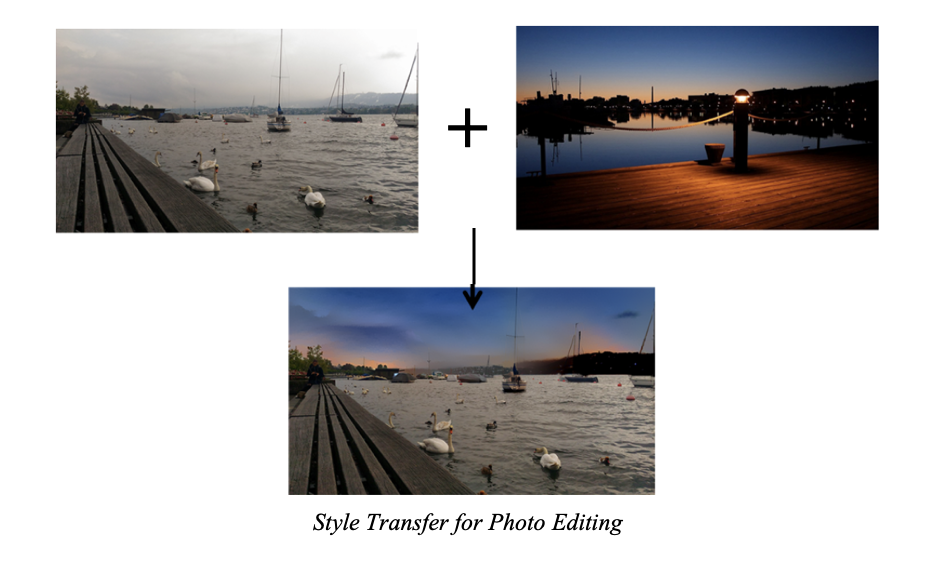

# 3. Related Work

Neural Style Transfer has a large number of applications in the computer vision domain. However, it is far less explored to edit images and produce professionally edited like images from their raw forms. The previous works merely list editing images as a benefit of their modules, but not many deliberate efforts have been put in to apply neural style transfer for editing images.

There are a few research papers that work around using style transfer for specific vision applications, and there are others that build modules for general style transfer between any two types of images. For our use case, we mainly explored the second type of method because the others are highly tuned for a specific task. We use the Deep Photo Style Transfer by Fujun Luan et al. as our base method for this project, make novel changes to improve their style transfer procedure, and build an additional module that automatically selects the best style image from our curated dataset to edit the given input image. This is an end-to-end pipeline and takes as input just the input image and input segmentation files to generate the edited stylized image.

## 3.1 Deep Photo Style Transfer (DPST)

DPST is a generative algorithm. The algorithm takes two images as input, the input image, and the reference style image. The model aims to transfer the style of the reference image to the input image with photo realism while preserving its overall structure. This algorithm is built over the method proposed by Gatys et al. in their work "Image Style Transfer Using Convolutional Neural Networks." 

Suppose we have a style image S and an input image I, and we want to produce an output image O. The objective function they use to minimize is given by: 

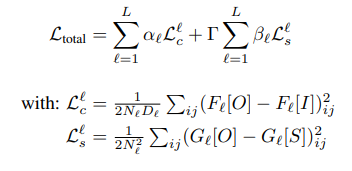 

Here L is the total number of convolutional layers. There are Nl number of filters in each layer, with a vectorized feature map of size Dl. The weights alpha and beta are weights for each layer, and lambda balances the amount of style to be transferred. Fl is a feature matrix, and Gl is the gram matrix defined as the inner product between the vectorized feature maps. 

DPST adds a photorealism regularization term which helps to preserve the structure of the input image and produce photorealistic output images. This idea is the first and very efficient attempt at this problem. They assume that the input image is already photorealistic and then ensure that during their process, they do not lose this property. For this, they add a component to the loss term called affine loss. This term uses Matting Laplacian matrices, first introduced and used by Levin et al. in "A closed-form solution
to natural image matting." This is given by: 

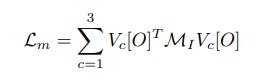 

We skip the further mathematical details of this part in the report, which are mentioned in great detail in the paper. 

The method by Gatys et al. uses a style term in the loss, but it has its limitations. This term uses a Gram matrix computed over the entire image, which encodes the exact distribution of the neural responses from the image. This makes the Gram matrix incapable of adapting to variations in the context and often leads to spillovers. To address this, DPST uses the segmentations of the input and style images to generate segmentation masks and use these as additional channels. The style loss component is then summed over all these channels. The computation of the Gram matrix still happens in the same way but on different inputs. 

Finally, all these three components of the loss function are added to compute the overall loss. DPST uses a pre-trained VGG-19 model for feature extraction from the input images. The output of conv4_2 (2nd convolutional layer of the 4th block of VGG) is used as the content representation, and the outputs of conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1 are used for style representations. 

The output image is initialized to a random noise of the same dimension as the required output. Using SGD and Adam optimizer, the pixels of this resultant image is updated over iterations using the loss from the work by Gatys. This image is saved as intermediate output. Again, taking this intermediate image as input, the same process is repeated, but this time with the new updated loss function from DPST. This final image is returned as the output. 

## 3.2 Comparison of DPST with Other Methods

The older methods, such as the one from Gatys et al., work well but still cannot handle the case of spillovers as described in the previous section. Another such transfer method is “Color transfer between images” by E. Reinhard et al. They used the idea of global color transformation to affect the image colors strongly, but not have any impact on the image structure. This method, however, has limited capabilities because it cannot model spatially varying effects and, thus, cannot faithfully transfer the style of the second image. These limitations are effectively addressed by DPST.

A few more recent works, such as "Photorealistic Style Transfer via Wavelet Transforms" by Jaejun Yoo et al., attempt the style transfer problem differently. They propose their own end-to-end model, called WCT2. This model also uses VGG-19 for feature extraction but has its own architecture involving wavelet pooling, unpooling layers. Instead of the output image being generated over iterations, WCT2 employs a progressive stylization strategy to generate the output in a single pass. There are also a few variations of the WCT2 model discussed in the paper, but they do not significantly outperform the DPST method. Another paper on "Arbitrary Style Transfer with Deep Feature Reshuffle" by Shuyang Gu et al. shuffles the feature maps of the images to connect their defined global and local style losses to generate output images.

Though these methods perform slightly better than DPST, they are not very useful in our scenario. These are end-to-end pipelines and therefore do not provide an explicit option to control the amount of style to be transferred. These methods generate the output image directly using their loss function and architectures. This leads to good artistic images, but we want to control the amount of style from the professionally edited style image to be transferred to the raw input image to be edited. This is why we used DPST as our base method for this project.

# 4. Methodology

For the purpose of this project, we have divided our timeline to having 3 major goals: 

1. First, we focus on a single class of image such as landscapes or cityscapes and try to perfect our model. Fixing such single class/reducing the number of classes has proven to be efficient in a few of the works discussed in the literature.

2. After this we plan to move on to other class, or produce an arbitrary or multiclass style transfer that allows portraits, wildlife etc. 

3. Following this we aim to automate the pipeline for multiple classes. The automation step is further explained in the following section.

## 4.1 Planned Network Architecture

There have been a few research papers published that produce good results for stylizing a content image using a style image. However, these techniques have not been applied to edit photos realistically and produce results good enough to eliminate the need for manual editing. For our project, we plan to follow the architecture similar to the paper Luan et al. [5] published in CVPR 2017. They improve the style transfer model but apply it to create stylized images and not to produce good editing of a photograph. Their method works well for their use case, and we believe we can extend it to ours as well.

The core idea of the algorithm is to obtain the features of the input image and the reference image and compute the Matting Laplacian matrices (similar to the work by Levin et al.) and Gram matrices. All these attributes are then used to create the target image. The target image is initialized as a copy of the input image and iteratively moves toward the style image. The loss consists of 3 components, two with weights that control the extent to which the target image is closer to the style or input image (style loss and content loss) and a regularization parameter.

The network architecture we use is to extract the features from the VGG-19 pre-trained model and choose the outputs of specific layers as feature extractions of the input and style images. This selection of layers here should be use-case-dependent, and we plan to figure these out as we progress in our project. For the style transfer in the reference paper, they use combinations of convolutional layers for this task. For computing the Gram and Matting Laplacian matrices, we plan to follow similar procedures as previous papers. Some papers also apply segmentation to the input and style images to help the model understand better in which sections of the image the style is to be applied and to what extent. We plan to add this part to our module if we have time after achieving the first goals of the project.

## 4.2 Style Automation

As mentioned in the Objectives section, one of our main goals for this project is to come up with a method to allow the automation of choosing a suitable style to edit our source image. Previous implementations of this problem statement require the user to manually provide both the content image (i.e., input) and style image. The network then provides the transfer image as output. However, this is a tedious process to do every time, especially when the user simply wants to enhance their image and not care about the different styles that they can use. In order to achieve this, we will work on two parts of the methodology that need to be automated. This is our enhancement to the existing implementations for the given problem statement.

### 4.2.1 Automation of Image Segmentation

In the paper mentioned above, we see that even though the style is transferred seamlessly, it is implied that the segmentation required for the stylistic transfer was done manually. This is not practical when introducing new data each time to the network. Hence, we must come up with a methodology that can account for this automatic segmentation.

Penhouet et. al.[12] provides a method of semantic grouping with the use of Neural Image Assessments. This eliminates the need for manually created segmentation masks for the training data of the network. This saves us and any future user the time it takes to create trainable data for the network at hand. They also introduce a semantic threshold keeping in mind the number of classes that we need the image to be segmented into. Decreasing this threshold, decreases the number of classes that can be segmented, but allows faster computation for the rest of the program.

For any supervised task, it's generally challenging to find labeled data as it requires a lot of manual labor to annotate them, and there are very few tasks that can be automatically annotated. Especially for the task of segmentation, where we need to classify pixels based on labels which makes it difficult to label the images.

To overcome this, we implement unsupervised segmentation by using convolutional networks. In the case of unsupervised scenarios, ground truth labels of pixels are not given beforehand. So, the feature representations of the target image, along with pixel labels, are optimized to obtain the segmentation. In our approach, we optimize them such that:

1. Pixels that are spatially aligned together will have the same label, and,
2. Pixels of similar feature representation need to have the same label. 

In our method, we minimize the softmax loss based on the estimated clusters.

When an input image is provided, the following steps are carried out. We freeze the model weights and learn the prediction clusters; then, the clusters are frozen, and the model parameters are learned. As in the general case of a neural network, the first step is the forward propagation step, where we predict the label, and the second step is the backpropagation that learns the model weight by updation using gradient descent.  In addition to the forward propagation step, we do a superpixel refinement to the clusters to make the prediction better.

We want to spatially group pixels together belonging to the same class, for which we add additional constraints. By letting the number of pixels in the superpixel be maximum, we select the most frequent cluster label.

This is the training details for the implementation described. A 2 layer CNN model is trained for 30 iterations per image to achieve the segmented image in each class. We take a learning rate of 0.1. The loss saturates and we get the image with each label colored in with different color marking each label.



### 4.2.2 Automation of Style Choice

More important to our mentioned objective, we must come up with a system where the network itself decides which style is more suitable for the input image at hand, and apply the style transfer for that image. This has not been done before, hence we must come up with our own methodology. 

Using the automatic segmentation method used above, we can obtain the same for the input content image. Then we can identify the nearest style image comparing the segmentation masks to identify the least difference between the input content image and style image. For this we use k nearest neighbors.

Once we identify the style closest to the input image, we transfer the style of the image and apply it to the input image. The result is the transfer image of a better stylistic choice that was not manually chosen by the user. Hence, this is the ideal solution for the problem we are trying to solve.


## 4.3 Implementation Details and Novel Changes

The code from the authors of DPST was implemented in an older version of python and Tensorflow version 1 and had several incompatibility issues. We worked around these to upgrade the complete code to Tensorflow version 2.4.1 and python 3.8. Making the exact versions of TensorFlow, Keras, NumPy, pillow, python, scipy, etc., compatible with each other and getting the code base running was in itself a huge challenge which took several hours to get executable. 

The DPST method uses the VGG-19 model for feature extraction, as described in the previous section. Since we know that Resnet performs better for the classification task, we tried extracting the feature vectors using Resnet. Still, the final output images could not faithfully transfer the style of the reference image. In some cases, the structure of the input image also got distorted somewhat more as compared to VGG. On reading more about this, we got to know that VGGs have inherent stability and inability to learn non-robust features of images, which makes them the best choice for feature extractor for our use case.

The code from the authors of DPST uses a pre-trained VGG model on a dataset different from imagenet. Therefore, we changed this part to use the pre-trained VGG-19 model from Tensorflow on imagenet. This model architecture was slightly different from the ones the authors used, so we made several changes in the styling method to adapt to these. This VGG from TensorFlow is optimized for the classification task, which is significantly different from our use case. Therefore, we decided to use transfer learning, as discussed in the lectures and homework assignments, to make the VGG-19 model adapt to our use case of style transfer. 

The VGG-19 model has the last two layers as fully connected layers and a 1000 class prediction layer. We modified these to be a fully-connected layer with 1024 hidden units and the final layer as a 3-class prediction layer using softmax. These three classes it predicts are from our newly curated dataset, namely, portraits, landscape, and wildlife. Apart from these last two layers, all other model layers are frozen for training, and the model is trained for five epochs on our newly curated dataset. Next, all layers are unfrozen, and the complete model is trained again on the same data. This transfer learning technique helped the VGG-19 model to get fine-tuned to our use case of image style transfer on our data. This newly trained model is then saved so that the training does not need to be done every time we want to edit an image. With this transfer-learned model, we achieved more stable images with slightly fewer distortions on the same input and reference style images. That is why we proceeded with this model. 

DPST uses three components for the loss function described in the previous section. We decided to add a new component to this loss function, which we thought about and implemented from scratch. The features extracted from the images using our new VGG-19 model are the combinations of outputs of certain model layers. These feature vectors are used to compute the loss component value. We consider the different elements of these feature vectors to be different dimensions. Therefore, flattening these feature values gives us a vector in some n-dimension space, where n is the number of feature values extracted. This is a positional vector considering the origin to have all zero values. We obtain such vectors for the features of input and style images. Next, we compute the cosine of the angle between these two vectors using the dot product. We want the features extracted to be aligned together and therefore want this angle to be as small as possible. The intuition is that since we are starting from a random noise image, we want this image to be aligned with the style image features. We did not directly use the images and used the extracted features because the previous case would result in the output image getting very, very close to the style image, which is not ideal. Since this is a component of the loss function, we use the reciprocal of cosine (sec) as the loss component value. To summarize, the function computes the norm of the two feature maps and their sum of element-wise products. The multiplication of both norms is divided by this sum to obtain the loss component value. 

Combining all these novel additions to the DPST model, we achieved better results. The output images had slightly fewer distortions and were more structurally similar to the input image, still faithfully having the style of the reference image.


# 5. Experiments

## 5.1 Dataset

The datasets typically used for this application include ImageNet[9] the world’s largest visual recognition and classification dataset, COCO Dataset largescale object detection and captioning data, and  Cityscapes dataset[10] which focuses on segmentation data of urban street scenes. A few datasets specific to our application include CMP faced dataset which includes 606 rectified images of facades from various sources and  WikiArt data which consists of over 150 thousand painting images by 2500 artists. The images in the dataset were collected and annotated by WikiArt  and was proposed in[11]. 

In our method we aim to use a few photos taken in our mobile phones(that is, images not having a high quality) and to use images online that have specific features like good exposure, brightness and lighting and transfer its style to our low-quality images.

 

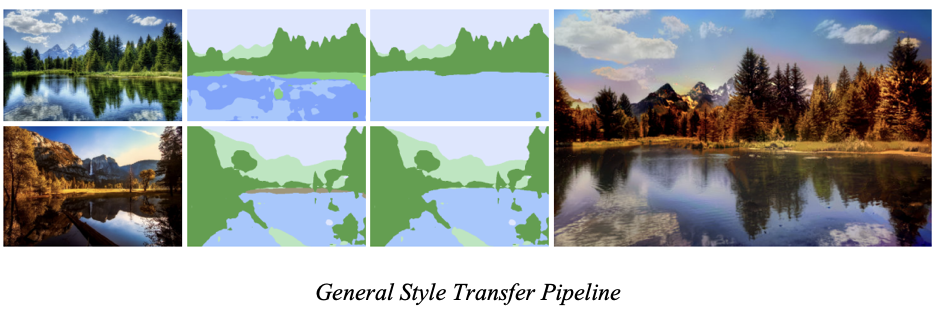

## 5.2 Data Generation

To train our model for the purpose of our implementation, the data is generated from scratch. We consider 3 main classes of images: wildlife, portraits, and landscapes, on which we apply style transfer. We employ web scraping to extract those images using Python script from scratch that uses Selenium web automation and testing library and BeautifulSoup to web scrape and download images from Google Images.

In order to obtain high-quality images for the purpose of feature extraction by the style transfer model and segmentation, the images are extracted from their original source using the python-requests library. This ensures that we get high-resolution images rather than the ones loaded on the web browser content.

We get 120 images in each class since we are using pre-trained weights for most of the layers, and only the last few layers are learned. Separate demo images are collected for the purpose of testing our performance.

The style transfer model requires an image along with the segmented mask of it, how the segmentation mask is obtained is explained below.

## 5.3 Demonstration

## 5.4 Inferences and Other Results

# 6. Conclusion

# 7. Bibliography

*[1]	L. Zhong, N. Li and Y. Sun, "Research and Application of Image Style Transfer Method," 2022 IEEE 8th Intl Conference on Big Data Security on Cloud (BigDataSecurity), IEEE Intl Conference on High Performance and Smart Computing, (HPSC) and IEEE Intl Conference on Intelligent Data and Security (IDS), 2022, pp. 143-147, doi: 10.1109/BigDataSecurityHPSCIDS54978.2022.00035.*

*[2]	X. Shi and W. Hu, "A Survey of Image Style Transfer Research," 2022 2nd International Conference on Computer Science, Electronic Information Engineering and Intelligent Control Technology (CEI), 2022, pp. 133-137, doi: 10.1109/CEI57409.2022.9950226.*

*[3]	Ashikhmin, N. "Fast texture transfer." IEEE computer Graphics and Applications 23.4 (2003): 38-43.*

*[4]	Efros, Alexei A., and William T. Freeman. "Image quilting for texture synthesis and transfer." Proceedings of the 28th annual conference on Computer graphics and interactive techniques, 2001.*

*[5]	Luan, Fujun, et al. "Deep photo style transfer." Proceedings of the IEEE conference on computer vision and pattern recognition, 2017.*

*[6]	Johnson, Justin, Alexandre Alahi, and Li Fei-Fei. "Perceptual losses for real-time style transfer and super-resolution." European conference on computer vision. Springer, Cham, 2016.*

*[7]	Chen, Dongdong, et al. "Stylebank: An explicit representation for neural image style transfer." Proceedings of the IEEE conference on computer vision and pattern recognition, 2017.*

*[8]	Huang, Xun, and Serge Belongie. "Arbitrary style transfer in real-time with adaptive instance normalization." Proceedings of the IEEE international conference on computer vision, 2017.*

*[9]	Deng, J., Dong, W., Socher, R., Li, L. J., Li, K., & Fei-Fei, L. (2009, June). Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition (pp. 248-255), IEEE.*

*[10]	Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., ... & Schiele, B. (2016). The cityscapes dataset for semantic urban scene understanding. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3213-3223).*

*[11]	Tan, W. R., Chan, C. S., Aguirre, H. E., & Tanaka, K. (2016, September). Ceci n'est pas une pipe: A deep convolutional network for fine-art paintings classification. In 2016 IEEE International Conference on Image Processing (ICIP) (pp. 3703-3707), IEEE.*

*[12]	Penhouët, Sebastian, and Paul Sanzenbacher. "Automated deep photo style transfer." arXiv preprint arXiv:1901.03915 (2019).*